## Worksheet 06
***

### Red Card Study
**Crowdsourcing data analysis: Do soccer referees give more red cards to dark skin toned players?**

In [1]:
import os

import numpy as np
import random
import scipy.stats.mstats as ssm
from scipy.stats import gaussian_kde as kde

from utils import (mean_squared_error, k_fold_cv)

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model
from regression_tree import RegressionTree

from data.data_preparation import data_preparation
from data.my_dataset import MyDataset

%load_ext autoreload
%autoreload 2

In [2]:
# Load data
filename = os.path.join('data', 'CrowdstormingDataJuly1st.csv')
df = pd.read_csv(filename)

A referee-player dyad describes the interactions between a particular ref and one player. This means that each row in the dataset is of a unique player-ref combination, listing all of the games by a given player with a particular referee at any point in his career.

Let's have a look at the first few rows of the data set to have a better understanding

In [3]:
df.iloc[:10, :]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


#### Some stats of the data set

In [4]:
# Data Disaggregation
dfd = df.copy()
# Add new variables
dfd['skintone'] = (dfd['rater1'] + dfd['rater2']) / 2
dfd['allreds'] = dfd['yellowReds'] + dfd['redCards']
dfd['allredsStrict'] = dfd['allreds']
dfd['refCount'] = 0

# Add new feature tracking number of games per ref
refs = np.unique(dfd['refNum'].values.ravel) # List all unique ref IDs

# Count dyads per ref
for r in refs:
    dfd['refCount'][dfd['refNum'] == r] = len(dfd[dfd['refNum'] == r])
    
col_names = list(dfd.columns)

j = 0
out = [0 for _ in range(sum(dfd['games']))]
for _, row in dfd.iterrows():
    n = row['games']
    c = row['allreds']
    d = row['allredsStrict']
    
    for _ in range(n):
        row['allreds'] = 1 if (c - _) > 0 else 0
        row['allredsStrict'] = 1 if (d - _) > 0 else 0
        rowlist=list(row)
        out[j] = rowlist
        j += 1

<ipython-input-4-7619ce08efb5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfd['refCount'][dfd['refNum'] == r] = len(dfd[dfd['refNum'] == r])


In [5]:
allRefs = dfd.refNum.value_counts()
print("Number of refs =", len(allRefs))
print("Number of dyads in the dataset =", sum(allRefs))
print("Median number of dyads per referee =", np.median(allRefs))

Number of refs = 3147
Number of dyads in the dataset = 146028
Median number of dyads per referee = 8.0


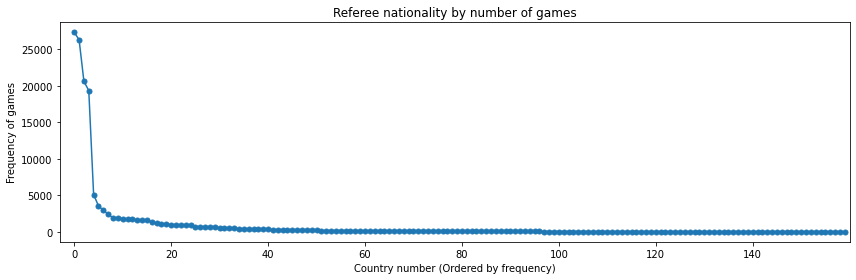

In [6]:
# Refs country frequency 'Alpha_3'
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x = dfd.Alpha_3.value_counts()
lines = ax.plot(x, marker='.', ms=10)
y = x.index.tolist()

ax.set_title('Referee nationality by number of games')
ax.set_xlabel('Country number (Ordered by frequency)')
ax.set_ylabel('Frequency of games')
ax.set_xlim([-3,160])
ax.set_xticks(np.arange(0, 160, step=20))
ax.set_xticklabels(np.arange(0, 160, step=20))

plt.tight_layout()
plt.show()

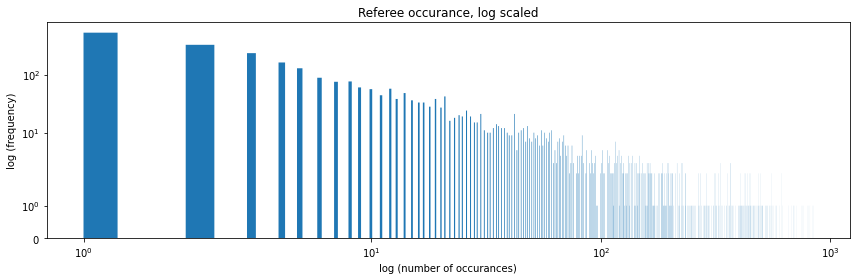

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(allRefs.tolist(), bins=len(allRefs), histtype='stepfilled', edgecolor='none')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_title("Referee occurance, log scaled")
ax.set_xlabel("log (number of occurances)")
ax.set_ylabel("log (frequency)")
# plt.xlim([1, 1000])
# plt.ylim([1,1000])
plt.tight_layout()
plt.show()

As we see, most games are refereed in Germany, England, France, and Spain. Moreover, most refs are only involved in a small number of dyads. On the other hand, many officiated over thousands. A median of 8.0 indicates that more than half of the refs officiated less than one game. If a ref officiated a full game in one of the 4 countries with more frequency of games, then he/she would be in at least 22 dyads (2 teams of 11 players each, more if substitutions occur).

The data is cleaned up by excluding interactions by refs who feature in fewer than 22 dyads

In [8]:
refs = allRefs[allRefs > 21]
print("Number of refs featuring in at least 22 dyads =",len(refs))
print("Number of dyads, excluding refs who officiate fewer than 22 games =", sum(refs))

Number of refs featuring in at least 22 dyads = 998
Number of dyads, excluding refs who officiate fewer than 22 games = 133501


In [9]:
# New data frame based o dyads filter
rfilt_dfd = dfd[dfd['refNum'].isin(refs.index.values)]

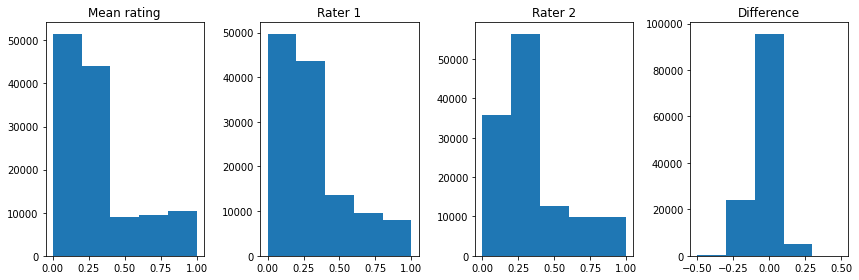

In [10]:
# Plot skin tone rating distribution
rated = ((dfd['rater1'] + dfd['rater2']) / 2).dropna()

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
colors = sns.color_palette()

ax[0].hist(rated, bins=5, range=(0, 1))
ax[0].set_title("Mean rating")

ax[1].hist(dfd['rater1'].dropna().tolist(), bins=5, range=(0, 1))
ax[1].set_title("Rater 1")

ax[2].hist(dfd['rater2'].dropna().tolist(), bins=5, range=(0, 1))
ax[2].set_title("Rater 2")

ax[3].hist((dfd['rater1'] - dfd['rater2']).dropna(), bins = 5, range = (-0.5,0.5))
ax[3].set_title("Difference")

plt.tight_layout()
plt.show()

In [11]:
# Cleaning data for solving problem
data, aggregated_data = data_preparation()

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object') 

Shape of the raw data:  (146028, 28) 

Number of unique playerShorts:  (1585,)
Number of unique players:  (1572,) 



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/juan19.99/Documents/JUAN/Uni_Heidelberg/MachineLearning/FML_Worksheet06/data/data_preparation.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)


In [12]:
# Cross-Validation to evaluate performance
data_set = MyDataset(data)

# Define models
linear_regression = linear_model.LinearRegression()
regression_tree = RegressionTree()

In [16]:
k = 10
for model in (linear_regression, regression_tree):
    print("Running: ", model)
    for feats_str in ("X_oc", "X_on", "X_oc_"):
        print("Dataset: %s" % feats_str)
        feats = eval("data_set.get_" + feats_str + "()")
        targets = data_set.targets
        assert feats.shape[0] == targets.shape[0]     
        err_train, std_err_train, err_test, std_err_test = k_fold_cv(model, feats, targets, k)
        print('test_err: %.2E' % err_test)
print("Done.")

Running:  LinearRegression()
Dataset: X_oc
test_err: 8.35E-05
Dataset: X_on
test_err: 9.73E-05
Dataset: X_oc_
test_err: 8.35E-05
Running:  <regression_tree.RegressionTree object at 0x7f9a9e073df0>
Dataset: X_oc
123 (1277, 13)
123 (13,)


AxisError: axis 1 is out of bounds for array of dimension 1